# <span style="color:red">S</span><span style="color:orange">e</span><span style="color:yellow">n</span><span style="color:green">t</span><span style="color:blue">i</span><span style="color:violet">m</span><span style="color:red">e</span><span style="color:orange">n</span><span style="color:yellow">t</span> Analysis

---
## Setup and Data loading

In [2]:
%%capture   
HF_HUB_DISABLE_SYMLINKS_WARNING = True

import os
import glob
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline, AutoTokenizer

output_dir = "Datum/"

nltk.download('vader_lexicon')

# Define paths
project_folder = './'  
text_files_folder = os.path.join(project_folder, 'Text_Files')

# Function to read file
def read_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read().strip()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return ""

# Read files in Text_Files
text_files_paths = glob.glob(os.path.join(text_files_folder, '*.txt'))
file_contents = [read_file(file_path) for file_path in text_files_paths]

# Filter out empty texts
file_contents = [text for text in file_contents if text]
text_files_paths = [file_path for file_path, text in zip(text_files_paths, file_contents) if text]

if not text_files_paths:
    raise ValueError("No valid content in Text_Files.")

print(f"Loaded {len(text_files_paths)} files.")


### Darth VADER Sentiment Analysis

In [3]:

# Initializing the death star
sid = SentimentIntensityAnalyzer()


vader_results = []
for file_path, content in zip(text_files_paths, file_contents):
    vader_scores = sid.polarity_scores(content)
    vader_results.append({
        'File Name': os.path.basename(file_path),
        'VADER Positive': vader_scores['pos'],
        'VADER Negative': vader_scores['neg'],
        'VADER Neutral': vader_scores['neu']
    })

# Convert to DataFrame
vader_df = pd.DataFrame(vader_results)
print(vader_df.head())

# Save VADER to CSV
vader_output_csv_path = output_dir + "vader_sentiment_results.csv"
vader_df.to_csv(vader_output_csv_path, index=False)
print(f"VADER sentiment results saved to: {vader_output_csv_path}")


                 File Name  VADER Positive  VADER Negative  VADER Neutral
0  fomcminutes20140129.txt           0.089           0.029          0.882
1  fomcminutes20140319.txt           0.082           0.056          0.862
2  fomcminutes20140430.txt           0.095           0.042          0.862
3  fomcminutes20140618.txt           0.083           0.051          0.866
4  fomcminutes20140730.txt           0.099           0.039          0.862
VADER sentiment results saved to: Datum/vader_sentiment_results.csv


### Bert Sentiment Analysis

In [50]:

bert_pipeline = pipeline("sentiment-analysis", model="finiteautomata/bertweet-base-sentiment-analysis")
bert_tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

# Function to truncate text properly
def truncate_text(text, tokenizer, max_length=128):
    tokens = tokenizer.tokenize(text)
    if len(tokens) > max_length - 2:  
        tokens = tokens[:max_length - 2]
    return tokenizer.convert_tokens_to_string(tokens)

bert_results = []
for file_path, content in zip(text_files_paths, file_contents):
    try:
        # Token limits are extremely constrained, max that Bart allows is 128 and even than I have to go even down
        truncated_content = truncate_text(content, bert_tokenizer, max_length=128)
        bert_result = bert_pipeline(truncated_content, truncation=True, max_length=128)[0]
        bert_results.append({
            'File Name': os.path.basename(file_path),
            'BERT Sentiment': bert_result['label'],
            'BERT Score': bert_result['score']
        })
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Convert to DataFrame
bert_df = pd.DataFrame(bert_results)
print(bert_df.head())

# Save BERT results to CSV
bert_output_csv_path = output_dir + "bert_sentiment_results.csv"
bert_df.to_csv(bert_output_csv_path, index=False)
print(f"BERT sentiment results saved to: {bert_output_csv_path}")


                 File Name BERT Sentiment  BERT Score
0  fomcminutes20140129.txt            NEU    0.976904
1  fomcminutes20140319.txt            NEU    0.979308
2  fomcminutes20140430.txt            NEU    0.979265
3  fomcminutes20140618.txt            NEU    0.979330
4  fomcminutes20140730.txt            NEU    0.979664
BERT sentiment results saved to: Datum/bert_sentiment_results.csv


### FinBERT Sentiment Analysis

In [51]:
finbert_pipeline = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")
finbert_tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

# Apply FinBERT sentiment analysis
finbert_results = []
for file_path, content in zip(text_files_paths, file_contents):
    truncated_content = truncate_text(content, finbert_tokenizer)
    finbert_result = finbert_pipeline(truncated_content)[0]
    finbert_results.append({
        'File Name': os.path.basename(file_path),
        'FinBERT Sentiment': finbert_result['label'],
        'FinBERT Score': finbert_result['score']
    })

# Convert to DataFrame
finbert_df = pd.DataFrame(finbert_results)
print(finbert_df.head())

# Save FinBERT results to CSV
finbert_output_csv_path = output_dir + "finbert_sentiment_results.csv"
finbert_df.to_csv(finbert_output_csv_path, index=False)
print(f"FinBERT sentiment results saved to: {finbert_output_csv_path}")

c:\Users\ih8l1\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


                 File Name FinBERT Sentiment  FinBERT Score
0  fomcminutes20140129.txt           Neutral       0.999994
1  fomcminutes20140319.txt           Neutral       0.999994
2  fomcminutes20140430.txt           Neutral       0.999994
3  fomcminutes20140618.txt           Neutral       0.999995
4  fomcminutes20140730.txt           Neutral       0.999994
FinBERT sentiment results saved to: Datum/finbert_sentiment_results.csv


### RoBERTa Sentiment Analysis

In [52]:
roberta_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
roberta_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Apply RoBERTa sentiment analysis
roberta_results = []
for file_path, content in zip(text_files_paths, file_contents):
    truncated_content = truncate_text(content, roberta_tokenizer)
    roberta_result = roberta_pipeline(truncated_content)[0]
    roberta_results.append({
        'File Name': os.path.basename(file_path),
        'RoBERTa Sentiment': roberta_result['label'],
        'RoBERTa Score': roberta_result['score']
    })

# Convert to DataFrame
roberta_df = pd.DataFrame(roberta_results)
print(roberta_df.head())

# Save RoBERTa results to CSV
roberta_output_csv_path = output_dir + "roberta_sentiment_results.csv"
roberta_df.to_csv(roberta_output_csv_path, index=False)
print(f"RoBERTa sentiment results saved to: {roberta_output_csv_path}")



c:\Users\ih8l1\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


                 File Name RoBERTa Sentiment  RoBERTa Score
0  fomcminutes20140129.txt           LABEL_1       0.940970
1  fomcminutes20140319.txt           LABEL_1       0.942285
2  fomcminutes20140430.txt           LABEL_1       0.936826
3  fomcminutes20140618.txt           LABEL_1       0.937327
4  fomcminutes20140730.txt           LABEL_1       0.941848
RoBERTa sentiment results saved to: Datum/roberta_sentiment_results.csv


In [6]:
vader_df = pd.read_csv(output_dir + "vader_sentiment_results.csv")
bert_df = pd.read_csv(output_dir + "bert_sentiment_results.csv")
finbert_df = pd.read_csv(output_dir + "finbert_sentiment_results.csv")
roberta_df = pd.read_csv(output_dir + "roberta_sentiment_results.csv")

print(vader_df.head(), "\n")
print(bert_df.head(), "\n")
print(finbert_df.head(), "\n")
print(roberta_df.head(), "\n")


                 File Name  VADER Positive  VADER Negative  VADER Neutral
0  fomcminutes20140129.txt           0.089           0.029          0.882
1  fomcminutes20140319.txt           0.082           0.056          0.862
2  fomcminutes20140430.txt           0.095           0.042          0.862
3  fomcminutes20140618.txt           0.083           0.051          0.866
4  fomcminutes20140730.txt           0.099           0.039          0.862 

                 File Name BERT Sentiment  BERT Score
0  fomcminutes20140129.txt            NEU    0.976904
1  fomcminutes20140319.txt            NEU    0.979308
2  fomcminutes20140430.txt            NEU    0.979265
3  fomcminutes20140618.txt            NEU    0.979330
4  fomcminutes20140730.txt            NEU    0.979664 

                 File Name FinBERT Sentiment  FinBERT Score
0  fomcminutes20140129.txt           Neutral       0.999994
1  fomcminutes20140319.txt           Neutral       0.999994
2  fomcminutes20140430.txt           Neutral    

In [7]:
plot_data = pd.DataFrame({
    'File Name': vader_df['File Name'],
    'VADER Neutral': vader_df['VADER Neutral'],
    'BERT Score': bert_df['BERT Score'],
    'FinBERT Score': finbert_df['FinBERT Score'],
    'RoBERTa Score': roberta_df['RoBERTa Score']
})

# Sort data by File Name for plotting
plot_data = plot_data.sort_values(by='File Name')

print("Data prepared for plotting.")
print(plot_data.head())


Data prepared for plotting.
                 File Name  VADER Neutral  BERT Score  FinBERT Score  \
0  fomcminutes20140129.txt          0.882    0.976904       0.999994   
1  fomcminutes20140319.txt          0.862    0.979308       0.999994   
2  fomcminutes20140430.txt          0.862    0.979265       0.999994   
3  fomcminutes20140618.txt          0.866    0.979330       0.999995   
4  fomcminutes20140730.txt          0.862    0.979664       0.999994   

   RoBERTa Score  
0       0.940970  
1       0.942285  
2       0.936826  
3       0.937327  
4       0.941848  


### Plotting

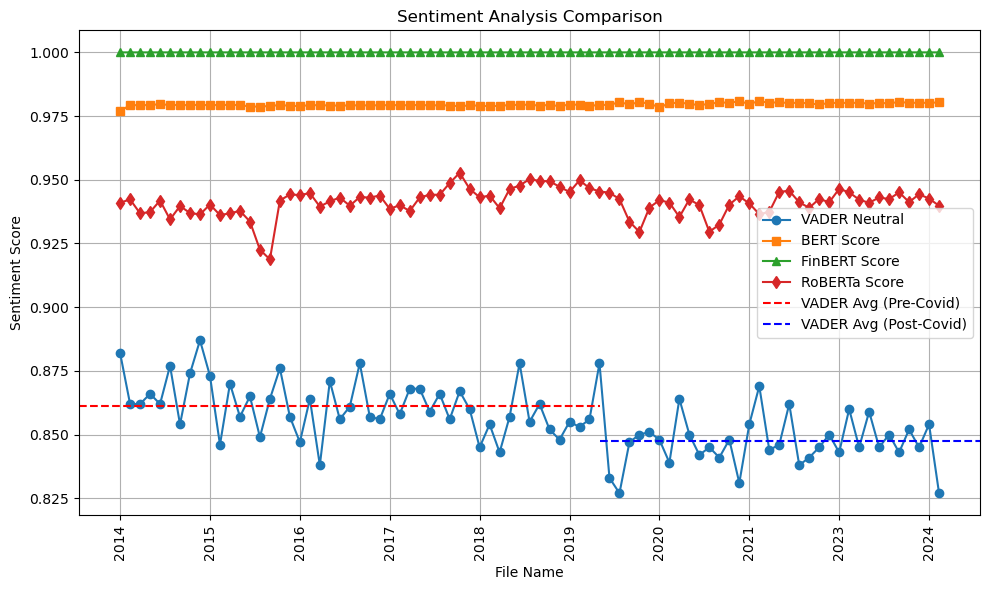

In [17]:
import matplotlib.pyplot as plt

linea = 48

# Calculate the averages
vader_neutral_first_avg = plot_data['VADER Neutral'][:linea].mean()
vader_neutral_rest_avg = plot_data['VADER Neutral'][linea:].mean()

plt.figure(figsize=(10, 6))  #

# Plot each sentiment result as a line
plt.plot(plot_data['File Name'], plot_data['VADER Neutral'], label='VADER Neutral', marker='o')
plt.plot(plot_data['File Name'], plot_data['BERT Score'], label='BERT Score', marker='s')
plt.plot(plot_data['File Name'], plot_data['FinBERT Score'], label='FinBERT Score', marker='^')
plt.plot(plot_data['File Name'], plot_data['RoBERTa Score'], label='RoBERTa Score', marker='d')


plt.axhline(y=vader_neutral_first_avg, color='r', linestyle='--', label='VADER Avg (Pre-Covid)', xmax=linea/len(plot_data['File Name']))
plt.axhline(y=vader_neutral_rest_avg, color='b', linestyle='--', label='VADER Avg (Post-Covid)', xmin=linea/len(plot_data['File Name']))


plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis Comparison')
plt.legend()

# Naming by year
x_labels_full = plot_data['File Name']
x_labels_trimmed = [name[11:15] if len(name) >= 15 else name for name in x_labels_full]

# 
x_ticks = range(0, len(x_labels_trimmed), 9)
plt.xticks(ticks=x_ticks, labels=[x_labels_trimmed[i] for i in x_ticks], rotation=90)  # Rotate x-axis labels for better readability

plt.grid(True)
plt.tight_layout()

plt.show()
